# What is the `StridedDataset`

The strided dataset is a dataset that decouples the length of the simulation, from the prediction horizion for our neural network.
It does this by "chunking" sequences of length $N$ into smaller subsequences of length $L$ spaced `stride` apart from eachother in the orginal sequence, where $L$ and `stride` are hyperparameters to tune over.

<center> <img src="https://www.aimspress.com/aimspress-data/mbe/2019/6/PIC/mbe-16-06-331-g001.jpg"> </center>
<center> Haibo Li,  Juncheng Tong. A novel clustering algorithm for time-series data based on precise correlation coefficient matching in the IoT[J]. Mathematical Biosciences and Engineering, 2019, 16(6): 6654-6671. doi: 10.3934/mbe.2019331 </center>


# Why would I want to use the `StridedDataset`

Many of the problems where neuromancer can be greatly beneficial, require system identification.
System identification is a process in which you train a black box neural net to learn to behave like a specific autonomous or non-autonomous system.
The way that you do this is by training it on "state-action" tuple pairs, and having it predict the subsequent state: $(y, u) \rightarrow (\hat y)$.
In neuromancer using the `trainer` and `DictDataset` means that if you have a sequence of length $N$, during training your system identification model will auto-regressively predict the subsequent states for those $N$ samples in the sequence.
This can lead to slower training times because you then have to backpropagate through the entire sequence length, and since you are backpropagating through the entire sequence, it becomes easier for your black box to start predicting the mean of your dataset to minimize the penalty encurred.

All that to say that it can be greatly beneficial for neural networks to predict smaller subsequences to learn more general trends about the data.

# How do I use the `StridedDataset`

Using the `StridedDataset` is exceptionally similar to using the `DictDataset` class with three addtional paramters:


| Param | Description | 
| --- | --- | 
| `L` | This is the desired legnth of each subsequence from the original sequence(s) |
| `stride` | This is the desired spacing between each subsequence created from the original sequence(s) |
| `update_yn` | This is the function that will select the key for your rollout, for example if you are trying to predict the sequence "Y", you would create a callable that selects the initial condition for your rollout of this sequence |



# Let's Get Started

First we need some data, for this we will just use a small `sin` and `cos` example dataset so that we can see the subsequences that we are creating.

In [36]:
import numpy as np

sequence_dataset = {
    "X": np.linspace(0, 4 * np.pi, 100),
    "Y": np.linspace(0, 4 * np.pi, 100),
}

sequence_dataset = {k: v[None, :, None] for k, v in sequence_dataset.items()}
sequence_dataset["X"] = np.sin(sequence_dataset["X"])
sequence_dataset["Y"] = np.cos(sequence_dataset["Y"])

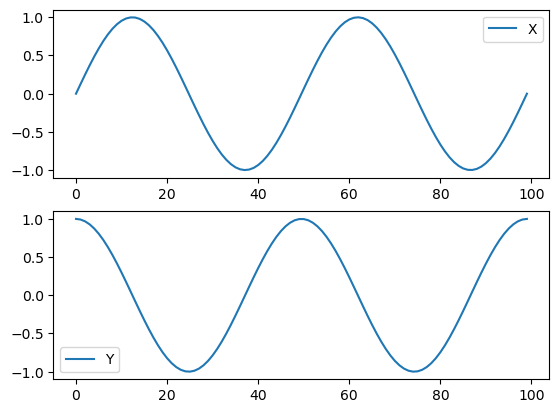

In [37]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)
ax[0].plot(sequence_dataset["X"].squeeze(), label="X")
ax[0].legend()
ax[1].plot(sequence_dataset["Y"].squeeze(), label="Y")
ax[1].legend()
plt.show()


# Creating the `StridedDataset` object

Now that we have our simple example data, lets create the `StridedDataset` object, for this demonstration we are going to set the stride to one for simple demonstration purposes, but it is greatly encouraged that you open this notebook in an interactive environment and tune these paramters to visually see what they are doing!

In [38]:
from neuromancer.dataset import StridedDataset

def update_initial_condition(d):
    d['yn'] = d["Y"][0:1, :]
    return d

strided_dataset = StridedDataset(
    datadict=sequence_dataset,
    L=10,                               # TUNE: sequence length
    stride=1,                           # TUNE: stride
    update_fn=update_initial_condition  # update function to add the initial condition to the dataset
)


{'X': array([[0.        ],
       [0.12659245],
       [0.25114799],
       [0.37166246],
       [0.48619674],
       [0.59290793],
       [0.69007901],
       [0.77614646],
       [0.84972543],
       [0.909632  ]]), 'Y': array([[1.        ],
       [0.99195481],
       [0.9679487 ],
       [0.92836793],
       [0.87384938],
       [0.80527026],
       [0.72373404],
       [0.63055267],
       [0.52722547],
       [0.41541501]]), 'yn': array([[1.]])}
{'X': (10, 1), 'Y': (10, 1), 'yn': (1, 1)}


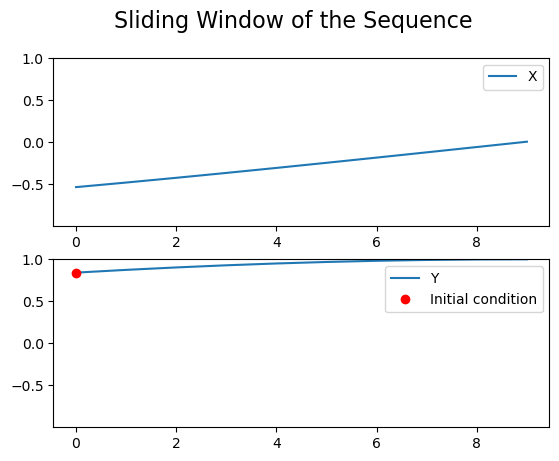

In [34]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Implemented this way so you can insert your data and visualize it
x_min, x_max = float('inf'), float('-inf')
y_min, y_max = float('inf'), float('-inf')
yn_min, yn_max = float('inf'), float('-inf')

for data in strided_dataset:
    x_min = min(x_min, data['X'].squeeze().min())
    x_max = max(x_max, data['X'].squeeze().max())
    y_min = min(y_min, data['Y'].squeeze().min())
    y_max = max(y_max, data['Y'].squeeze().max())
    yn_min = min(yn_min, data['yn'].squeeze().min())
    yn_max = max(yn_max, data['yn'].squeeze().max())

fig, ax = plt.subplots(2, 1)

fig.suptitle("Sliding Window of the Sequence", fontsize=16)

for i in range(len(strided_dataset)):
    ax[0].clear()
    ax[1].clear()
    
    ax[0].plot(strided_dataset[i]['X'].squeeze(), label="X")
    ax[0].legend()
    ax[0].set_ylim(y_min, y_max)
    
    ax[1].plot(strided_dataset[i]['Y'].squeeze(), label="Y")
    ax[1].legend()
    ax[1].set_ylim(min(y_min, yn_min), max(y_max, yn_max))
    
    # Mark a dot on the initial condition
    ax[1].plot(0, strided_dataset[i]['yn'].squeeze(), 'ro', label="Initial condition")
    ax[1].legend()

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')

    display(fig)
    clear_output(wait=True)
    time.sleep(0.1)

plt.close(fig)
